## Geometric Brownian Motion (GBM)

First, let's consider a Geometric Brownian Motion (GBM) model.

GBM is a stochastic process often used to model the evolution of stock prices over time. It assumes that the price follows a continuous-time random walk with a constant drift rate and volatility. Mathematically, the price S at time t is given by the following stochastic differential equation (SDE):

dS = mu * S * dt + sigma * S * dW

where:

* `dS`: The infinitesimal change in the stock price.
* `S`: The current stock price.
* `mu`: The drift rate, representing the expected return of the stock.
* `sigma`: The volatility, representing the standard deviation of the stock's returns.
* `dt`: An infinitesimal time increment.
* `dW`: A Wiener process, representing the random component of the price movement.

Solving this SDE leads to the following solution for the stock price at time t:

S(t) = S(0) * exp((mu - sigma^2/2) * t + sigma * W(t))

This equation implies that the stock price follows a log-normal distribution.

We simulate a Wiener Process by generating random numbers from a normal distribution and scaling those numbers to match the volatility of the asset.


For this example we are using ^NDXT closing prices from 2007-2016 to predict closing prices from 2017-2023. First let's load the data and calculate the basic statistics.

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# Get ^NDXT data
ndxt_df_past = yf.Ticker('^NDXT').history(start='2007-01-01', end='2017-01-01')
ndxt_df_pred = yf.Ticker('^NDXT').history(start='2017-01-02', end='2024-01-01')

# Calculate daily returns
returns = ndxt_df_past['Close'].pct_change().dropna()

# Estimate mean and standard deviation of returns
mu = returns.mean() * 252  # Annualized mean return
sigma = returns.std() * np.sqrt(252)  # Annualized volatility
print('Annualized mean returns:', mu)
print('Annualized volatility:', sigma)

Annualized mean returns: 0.12973831893433832
Annualized volatility: 0.2506048888461261


Then let's perform 1000 Monte Carlo simulations based on the GBM model described above.

In [41]:
# Run n simulations of a random walk
num_simulations = 1000
num_days = len(ndxt_df_pred)
simulated_prices = np.zeros((num_simulations, num_days))
simulated_prices[:, 0] = ndxt_df_past['Close'].iloc[-1]  # Starting price

# solution to stochastic differential equation for GBM:
# dS/S = (mu - 0.5 * sigma**2) * dt + sigma * dz
for i in range(1, num_days):
    simulated_prices[:, i] = simulated_prices[:, i - 1] * np.exp(
        (mu - 0.5 * sigma**2) * (1 / 252) + sigma * np.random.randn(num_simulations) * np.sqrt(1 / 252)
    )

# Calculate statistics for simulated prices at the end
final_prices = simulated_prices[:, -1]
print('Mean of final simulated prices:', final_prices.mean())
print('Standard deviation of final simulated prices:', final_prices.std())
print('Minimum of final simulated prices:', final_prices.min())
print('Maximum of final simulated prices:', final_prices.max())

Mean of final simulated prices: 7069.857414449622
Standard deviation of final simulated prices: 5030.79045914635
Minimum of final simulated prices: 577.6378866764189
Maximum of final simulated prices: 41971.854661350415


Now let's plot the results

In [42]:
# Align predictions with our date range
date_index = ndxt_df_pred.index

# Create DataFrame for simulated prices
simulated_df = pd.DataFrame(simulated_prices.T, index=date_index, columns=range(num_simulations))



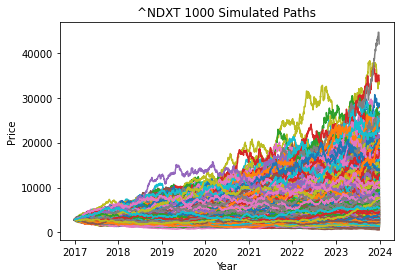

In [43]:
# Plot the simulated paths
plt.plot(simulated_df)
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('^NDXT 1000 Simulated Paths')
plt.show()

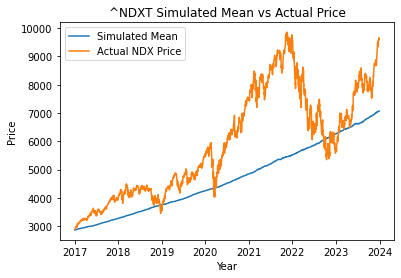

In [44]:

# Compare simulated mean with actual price path
plt.plot(simulated_df.mean(axis=1), label='Simulated Mean')
plt.plot(ndxt_df_pred['Close'], label='Actual NDX Price')
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('^NDXT Simulated Mean vs Actual Price')
plt.legend()
plt.show()

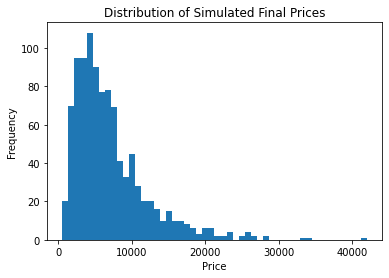

In [45]:
# plot histogram for distribution of simulated final prices
plt.hist(final_prices, bins=50)
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Simulated Final Prices')
plt.show()

**Value at Risk (VaR)** measures maximum potential loss of an investment over a time period for a given confidence level. In our case we use the Monte Carlo method for computing VaR. This considers the expected loss for the 5th percentile of our simulated paths. We output the resulting loss as a percentage of our initial investment.

In [50]:
# calculate 7 year 5% percentage VaR
var_level = 0.05
value_at_risk = ndxt_df_past['Close'][-1] - np.quantile(final_prices, var_level)
# Output result as a percentage of initial investment
value_at_risk_pct = (value_at_risk / ndxt_df_past['Close'][-1]) * 100
print('7 year', var_level * 100, '% VaR:', value_at_risk_pct)

7 year 5.0 % VaR: 34.07898182064052


To be clear, for our time period this means that in 95% of simulated cases this index will not drop by more than 34.08% 